In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [2]:
# Get the preprocessed X and y from the data.
def get_X_y():
    # Read in data.
    df = pd.read_csv('data/Boats_Cleaned_dataset.csv')
    df = df.fillna(0)

    # Delete selected rows with NaN.
    df = df[pd.to_numeric(df['zip'], errors='coerce').notnull()]
    df['zip'] = df['zip'].astype(int)
    df = df.drop(df[df['zip']==0].index)
    df = df.drop(df[df['engineCategory']==0].index)
    df = df.drop(df[df['beam_ft']==0].index)
    df = df.drop(df[df['totalHP']==0].index)

    # Delete selected columns with NaN
    df = df.drop(['Unnamed: 0','created_date','id','maxEngineYear','minEngineYear','dryWeight_lb', 'make', 'model','city','sellerId'],axis=1)

    # Define features and target.
    X0 = df.drop(['price'], axis=1)
    y0 = df.price

    # Standardize
    X_n = X0.select_dtypes(include='number')
    X_c = X0.select_dtypes(exclude='number')
    X_n = StandardScaler().set_output(transform='pandas').fit_transform(X_n)

    # Hot Encode
    X_c = pd.get_dummies(X_c, drop_first = False) #dropped first
    df = pd.concat([X_n,X_c,y0],axis=1)

    # Redefine features and target
    X = df.drop(['price'],axis=1)
    y = df.price

    return (X, y)

In [3]:
X, y = get_X_y()
print(X.shape)

(5752, 142)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# standardize features and convert back to dataframe
stnd = StandardScaler().set_output(transform='pandas')
X_train = stnd.fit_transform(X_train)
X_test = stnd.transform(X_test)

In [5]:
stnd = StandardScaler().set_output(transform='pandas')

poly = PolynomialFeatures(2,interaction_only=False,include_bias=False)
Xe_train = poly.fit_transform(X_train)
cols = poly.get_feature_names_out(X_train.columns)
Xe_train = pd.DataFrame(Xe_train, columns=cols)
Xe_train = stnd.fit_transform(Xe_train)
Xe_train['bias'] = 1
print(Xe_train.shape)
Xe_train.head()

Xe_test = poly.fit_transform(X_test)
cols = poly.get_feature_names_out(X_test.columns)
Xe_test = pd.DataFrame(Xe_test, columns=cols)
Xe_test = stnd.transform(Xe_test)
Xe_test['bias'] = 1
Xe_test.head()

(4601, 10296)


,year,length_ft,beam_ft,numEngines,totalHP,zip,created_month,created_year,type_power,type_sail,...,state_VT state_WA,state_VT state_WI,state_VT state_WV,state_WA^2,state_WA state_WI,state_WA state_WV,state_WI^2,state_WI state_WV,state_WV^2,bias
0,0.458768,0.376058,-0.041683,-0.380039,-0.012794,0.022301,-0.628472,0.667715,0.136369,-0.136369,...,0.084683,0.086624,0.058608,-0.142047,0.235036,0.075386,-0.20061,0.076745,-0.039035,1
1,0.041492,-0.584421,-0.278216,-0.380039,-0.348558,-1.446401,1.185771,-0.436186,0.136369,-0.136369,...,0.084683,0.086624,0.058608,-0.142047,0.235036,0.075386,-0.20061,0.076745,-0.039035,1
2,0.354449,-0.797861,-0.705685,-0.380039,-0.684321,-1.702834,0.883397,-1.540087,0.136369,-0.136369,...,0.084683,0.086624,0.058608,-0.142047,0.235036,0.075386,-0.20061,0.076745,-0.039035,1
3,0.354449,-0.797861,-0.064482,-0.380039,-0.567534,0.934702,1.790519,-2.643988,0.136369,-0.136369,...,0.084683,0.086624,0.058608,-0.142047,0.235036,0.075386,-0.20061,0.076745,-0.039035,1
4,0.458768,-0.264262,-0.090130,1.752350,1.009094,-0.592715,1.790519,-0.436186,0.136369,-0.136369,...,0.084683,0.086624,0.058608,-0.142047,0.235036,0.075386,-0.20061,0.076745,-0.039035,1


In [6]:
# regularize
grid = {'alpha':[750, 875, 1000, 1125, 1250]}
lasso = Lasso()
lassoCV = GridSearchCV(lasso,param_grid=grid,return_train_score=True)
lassoCV.fit(Xe_train,y_train)

print()
print('best alpha =',lassoCV.best_params_, '  valid R2 =',lassoCV.best_score_.round(3))

C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.668e+10, tolerance: 1.522e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e+10, tolerance: 1.426e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi


best alpha = {'alpha': 1125}   valid R2 = 0.791


fuelType_0 fuelType_diesel      -14572.618421
year type_power                 -14399.343041
year condition_new              -14221.818518
condition_new fuelType_0        -12226.271926
length_ft fuelType_0            -11001.107559
                                     ...     
length_ft                        38695.714186
totalHP                          52263.618201
length_ft totalHP                53037.103746
condition_new fuelType_diesel    55283.762719
year totalHP                     69218.251155
Length: 10296, dtype: float64

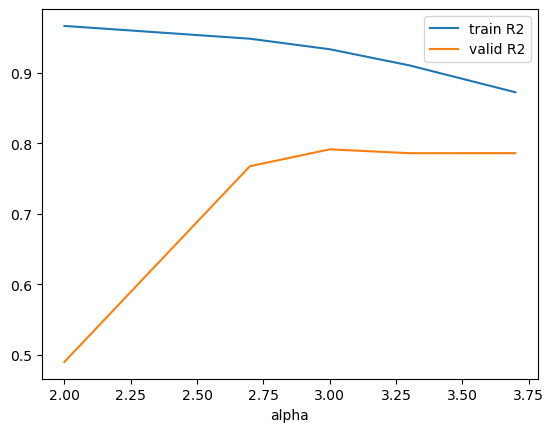

In [71]:
results = pd.DataFrame()
results['alpha'] = np.log10(grid['alpha'])
results['train R2'] = lassoCV.cv_results_['mean_train_score']
results['valid R2']  = lassoCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='alpha',y='train R2')
results.plot.line(x='alpha',y='valid R2',ax=ax1)

lasso = lassoCV.best_estimator_
coef = pd.Series(lasso.coef_,index=Xe_train.columns)
coef.sort_values()

In [72]:
print('Test R2: ', lassoCV.score(Xe_test,y_test))

Test R2:  0.8880704733617638



         best B = {'n_estimators': 60}
  validation R2 = 0.831


<Axes: xlabel='trees'>

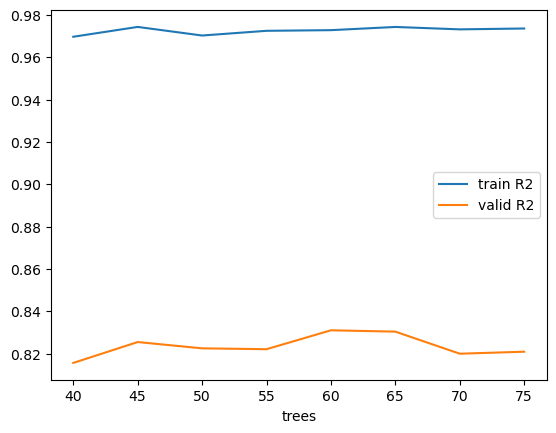

In [80]:
B = np.arange(40,80,5)
grid = {'n_estimators':B}

rf = RandomForestRegressor(max_features = 1/3)
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(Xe_train,y_train)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_.round(3))

results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2']  = rfCV.cv_results_['mean_test_score']
results.plot.line(x='trees',y=['train R2','valid R2'])

In [81]:
# oob score
rf = RandomForestRegressor(n_estimators=60,max_features = 1/3,oob_score=True)
rf.fit(Xe_train,y_train)
print('out-of-bag R2 =',rf.oob_score_.round(3))
print()
cv_results = cross_validate(rf,Xe_train,y_train,return_train_score=True)
R2_trainCV = cv_results['train_score'].mean()
R2_valid   = cv_results['test_score'].mean()
print('train R2 (CV) =',R2_trainCV.round(3),'  valid R2 =',R2_valid.round(3))
print()
R2_train = rf.score(Xe_train,y_train)
R2_test = rf.score(Xe_test, y_test)
print('     train R2 =',R2_train.round(3),
      '     test  R2 =', R2_test.round(3))

out-of-bag R2 = 0.803

train R2 (CV) = 0.972   valid R2 = 0.828

     train R2 = 0.973      test  R2 = 0.886


In [100]:
filtered_coef = coef.drop(coef[coef.apply(lambda x: (x < 0.0001) & (x > -0.0001))].index)
filtered_coef

year                 19799.068388
length_ft            38695.714186
beam_ft                208.655140
numEngines            3249.527081
totalHP              52263.618201
                         ...     
state_KY state_SC     -545.677114
state_NJ state_NY      117.887456
state_NY state_OH       45.121871
state_NY state_WI      216.719189
state_SC state_WA     -366.875920
Length: 285, dtype: float64

In [101]:
rf = RandomForestRegressor(n_estimators=60,max_features = 1/3,oob_score=True)
rf.fit(Xe_train[filtered_coef.index.to_list()],y_train)
print('out-of-bag R2 =',rf.oob_score_.round(3))
print()

out-of-bag R2 = 0.826



In [103]:
print('TrainR2:', rf.score(Xe_train[filtered_coef.index.to_list()], y_train))
print('TestR2:', rf.score(Xe_test[filtered_coef.index.to_list()], y_test))

TrainR2: 0.9735738317187799
TestR2: 0.9292151000364743
